## This notebook brings you through the syllabification process one step at a time, to refine/visualize the algorithm
- This notebook takes WAV datasets generated by `1.0-segment-song-from-wavs` and segments the WAV into syllables 
  - WAVs are expected to be in this format: `2017-04-16_17-27-44-760000.wav`
- The notebook outputs a textgrid file with a correslponding to the WAV


### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from datetime import datetime
import pandas as pd
import copy

In [3]:
from avgn.utils.audio import load_wav, int16_to_float32
from avgn.utils.paths import DATA_DIR, ensure_dir
from avgn.utils.general import save_dict_pickle
from avgn.bout_segmentation.dynamic_threshold_segmentation import (
    dynamic_spectrogram,
    contiguous_regions,
    cut_syllables,
    boundaries_to_textgrid,
)
from avgn.visualization.spectrogram import (
    plot_segmentations,
    plot_bout_to_syllable_pipeline,
)
from avgn.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Parameters for segmenting syllables

In [4]:
# the size of the syllables (pixels*pixels)
syll_size = 128

# parameters for filtering
filtering_params = {
    # filtering
    "highcut": 15000,
    "lowcut": 500,
}

spectrogramming_params = {
    # spectrograms
    "mel_filter": False,  # should a mel filter be used?
    "num_freq": 512,  # how many channels to use in a spectrogram
    "sample_rate": 44100,  # what rate are your WAVs sampled at?
    "preemphasis": 0.97,
    "min_silence_for_spec": 0.5,  # minimum length of silence for a spectrogram to be considered a good spectrogram
    "max_vocal_for_spec": 5.0,  # the longest a single vocalization (protosyllable) is allowed to be
    "frame_shift_ms": 0.5,  # step size for fft
    "frame_length_ms": 6,  # frame length for fft
    "min_level_dB": -80,  # minimum threshold db for computing spe
    "min_level_dB_floor": -20,  # (db)
    "spec_thresh_delta_dB": 5,  # (db) what
    "ref_level_dB": 20,  # reference db for computing spec
    "sample_rate": 44100,  # sample rate of your data
}

envelope_params = {
    # Vocal Envelope
    "smoothing": "gaussian",  # 'none',
    "envelope_signal": "spectrogram",  # spectrogram or waveform, what to get the vocal envelope from
    "gauss_sigma_s": 0.0001,
    "FOI_min": 4,  # minimum frequency of interest for vocal envelope (in terms of mel)
    "FOI_max": 24,  # maximum frequency of interest for vocal envelope (in terms of mel)
}

bout_threshold_params = {
    # Silence Thresholding
    "silence_threshold": 0.001,  # normalized threshold for silence
    "min_len": 5.0,  # minimum length for a vocalization (fft frames)
    "power_thresh": 0.3,  # Threshold for which a syllable is considered to be quiet weak and is probably noise
}

syllabification_params = {
    # Syllabification
    "min_syll_len_s": 0.03,  # minimum length for a syllable
    "segmentation_rate": 0.0,  # 0.125, # rate at which to dynamically raise the segmentation threshold (ensure short syllables)
    "min_num_sylls": 20,  # min number of syllables to be considered a bout
}

hparams = {
    'species': 'BF'
}
for d in [
    filtering_params,
    spectrogramming_params,
    envelope_params,
    bout_threshold_params,
    syllabification_params,
]:
    for k, v in d.items():
        hparams[k] = v

In [5]:
# this is used to identify this training instance
now_string = datetime.now().strftime(
    "%Y-%m-%d_%H-%M-%S"
)  
# save the dictionary so that we can reload it for recovering waveforms
dict_save = DATA_DIR / ("parameter_dictionaries/" + now_string + "_dict.pickle")
ensure_dir(dict_save)
save_dict_pickle(hparams, dict_save)
print(dict_save)

/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/data/parameter_dictionaries/2019-04-25_17-05-50_dict.pickle


### read WAV data

In [29]:
wav_loc = DATA_DIR / 'BF/Koumura_Okanoya/bouts/Bird0/wavs/1900-03-03_00-00-00-000000.wav'

In [30]:
# read in the data
csv_loc = wav_loc.parents[1]/'csv'/(wav_loc.stem + '.csv')
rate, data = load_wav(wav_loc)

In [8]:
hparams["sample_rate"] = rate

In [9]:
(bird, original_wav, start_time) = pd.read_csv(csv_loc, header=None).values[0]
start_time = datetime.strptime(start_time, "%Y-%m-%d_%H-%M-%S-%f")

In [10]:
# bandpass filter data
data = butter_bandpass_filter(data, hparams['lowcut'], hparams['highcut'], rate, order=2).astype('float32')

In [11]:
print('Rate: ', rate, 'Time sung: ',start_time, 'Length:', len(data)/float(rate))

Rate:  32000 Time sung:  1900-03-03 00:00:00 Length: 11.609


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

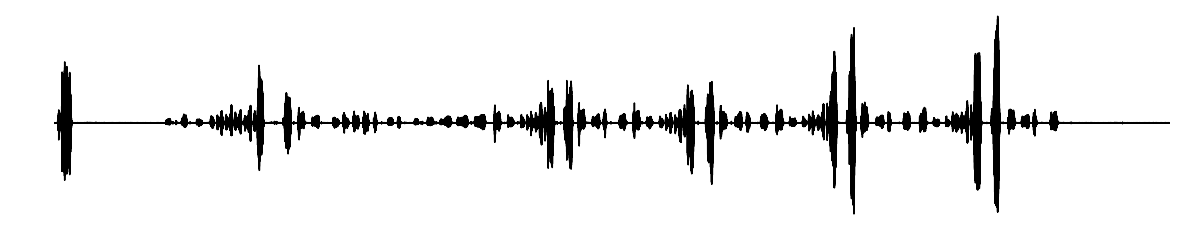

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(data, color='black')
ax.set_xlim((0, len(data)))
ax.axis('off')
plt.show()

In [14]:
# play back a sample of the song
IPython.display.Audio(data=data[:rate*10], rate=44100)

### Compute the spectrogram

In [15]:
# Generates the spectrogram and also thresholds out bad spectrograms (e.g. too noisy) - take a look at wav_to_syllables.py to determine if you want this
spec, vocal_envelope, cur_spec_thresh, fft_rate = dynamic_spectrogram(data/np.max(np.abs(data)), _mel_basis = None, hparams=hparams, verbose=True)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


longest silence 0.001
longest vocalization 10.8465
longest silence 0.001
longest vocalization 10.8465
longest silence 0.001
longest vocalization 5.9445
longest silence 0.001
longest vocalization 3.923


/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/avgn/bout_segmentation/dynamic_threshold_segmentation.py:88: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 0.0165
longest vocalization 0.247
longest silence 0.7995
longest vocalization 0.1595


<Figure size 432x288 with 0 Axes>

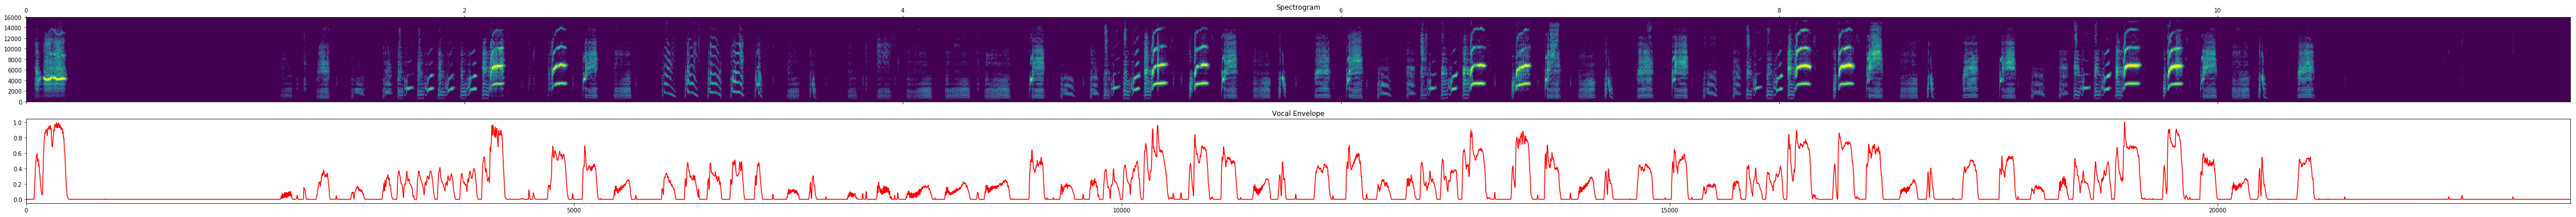

In [16]:
# visualize the generated spectrogram
plt.clf()
start_time = 0
stop_time = np.shape(spec)[1] / fft_rate
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(80, 6))

ax[0].matshow(
    spec,
    interpolation=None,
    aspect="auto",  # cmap=plt.cm.gray_r,
    cmap=plt.cm.viridis,
    origin="lower",
    extent=[start_time, stop_time, 0, rate / 2],
)
ax[0].set_title("Spectrogram")

ax[1].plot(vocal_envelope, color="red")
ax[1].set_xlim([0, len(vocal_envelope)])
ax[1].set_title("Vocal Envelope")
plt.show()

### Output some stats of our file

In [17]:
print("".join(["new Spectrogram Size: ", str(np.shape(spec))]))
print("".join(["Original Waveform Size: ", str(np.shape(data))]))
print("".join(["Length (s): ", str(len(data) / float(rate))]))
print("".join(["Original Sampling Rate (ms) : ", str(1.0 / float(rate))]))
print(
    "".join(
        [
            "New Sampling Rate (ms): ",
            str(round((len(data) / float(rate)) * 1000 / float(np.shape(spec)[1]), 3)),
        ]
    )
)

new Spectrogram Size: (512, 23219)
Original Waveform Size: (371488,)
Length (s): 11.609
Original Sampling Rate (ms) : 3.125e-05
New Sampling Rate (ms): 0.5


### Detect onsets and offsets of noise/vocalization

In [18]:
# Detect onsets and offsets of vocal envelope
onsets, offsets = np.array(
    contiguous_regions(vocal_envelope > hparams["silence_threshold"])
).T
print(onsets[0:10], offsets[0:10], len(onsets))

[   0   70  687  718 2321 2464 2532 2569 2647 2828] [   1  389  692  722 2435 2482 2559 2575 2780 2839] 138


### Segment into syllables

In [19]:
# segment into syllables based upon onset/offsets
all_syllables, all_syllable_starts, all_syllable_lens = cut_syllables(
    onsets, offsets, spec, fft_rate, hparams
)
# Timing for when each syllable started (seconds)
print(all_syllable_starts[0:5])

[0.0, 0.035, 0.3435, 0.359, 1.1605]


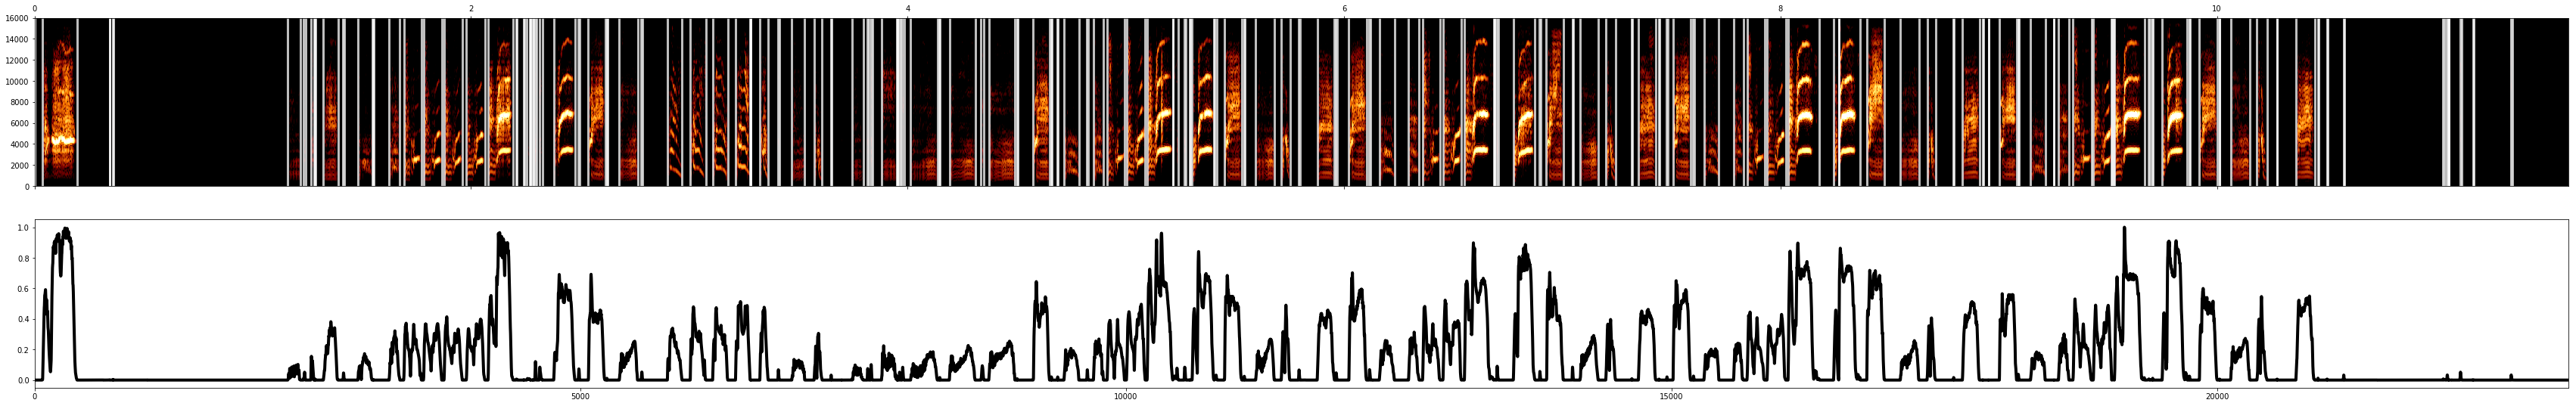

In [20]:
plot_segmentations(
    spec, vocal_envelope, all_syllable_starts, all_syllable_lens, fft_rate, hparams
)

### Threshold syllable lengths

In [21]:
print(len(all_syllable_lens))

138


0.0005 0.1595 0.042923913043478264
[0.0005, 0.1595, 0.0025, 0.002, 0.057]


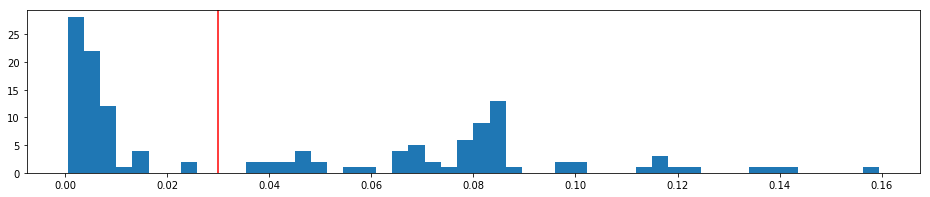

In [22]:
# Plot how we've thresholded out syllables which are too short to be considered song
print(np.min(all_syllable_lens), np.max(all_syllable_lens), np.mean(all_syllable_lens))
print(all_syllable_lens[0:5])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
_ = plt.hist(all_syllable_lens, bins=50)
ax.axvline(x=hparams["min_syll_len_s"], color="red")
plt.show()

In [23]:
syll_len_mask = np.array(all_syllable_lens) >= hparams["min_syll_len_s"]
all_syllables = [syll for syll, mask in zip(all_syllables, syll_len_mask) if mask]
all_syllable_starts = np.array(all_syllable_starts)[syll_len_mask]
all_syllable_lens = np.array(all_syllable_lens)[syll_len_mask]

In [24]:
len(all_syllables)

69

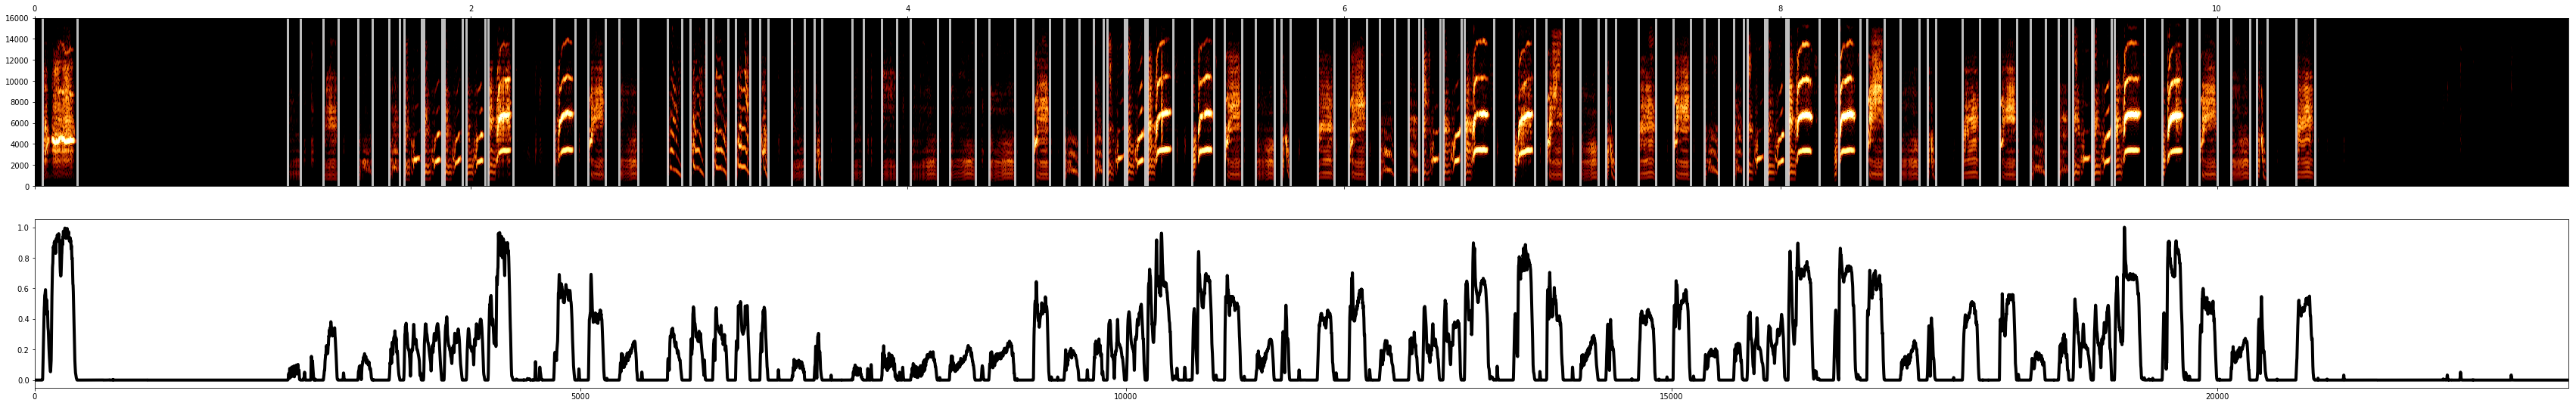

In [25]:
# plot again only with true syllables
plot_segmentations(
    spec, vocal_envelope, all_syllable_starts, all_syllable_lens, fft_rate, hparams
)

### Create textgrid

In [27]:
grid = boundaries_to_textgrid(all_syllable_starts, all_syllable_lens, )

In [28]:
grid.tierDict['syllables'].entryList[:3]

[Interval(start=0.035, end=0.1945, label='syll'),
 Interval(start=1.1605, end=1.2175, label='syll'),
 Interval(start=1.3235, end=1.39, label='syll')]